## CNN classifier for multi label tagging of Myntra fashion products

In [0]:
# Execute only in colab
!pip uninstall tensorflow
!pip install tensorflow==1.15.0

In [0]:
import numpy as np
import pandas as pd
import os
import PIL
import sys
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import keras
from keras.applications.vgg16 import VGG16
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD

from keras.preprocessing.image import load_img, img_to_array


##### If you are working on your local computer. Download and extract the dataset from https://www.kaggle.com/paramaggarwal/fashion-product-images-small
##### As the productDisplayName column in styles.csv needed modification. Extract only the images folder into your CNN_model_fashion_products_multi_label_tagging/images/ directory. Make use of styles.csv from this repository.

In [0]:
folder_path = os.getcwd()

Uninstalling tensorflow-2.2.0rc2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc2
     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 512kB 52.6MB/s 
     |████████████████████████████████| 3.8MB 68.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=85162e539d85ff470d825b59f02c269e74374e5ffb9df6d006def726673f94d7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstal

### Run below cell only in google colab
##### Upload your kaggle.json file into colab before you run below cell.
##### Download the kaggle.json file from your kaggle Profile/Account/API by clicking "Create New API Token".

In [0]:
!git clone https://github.com/sharathrjtr/CNN_model_fashion_products_multi_label_tagging.git
folder_path = os.path.join(folder_path, 'CNN_model_fashion_products_multi_label_tagging')

# Download the Kaggle Myntra fashion products small dataset
# For details: https://github.com/Kaggle/kaggle-api

# Two methods to authenticate your kaggle account. 

# Method 1: Fill in the details of username and key below from the kaggle.json.
# os.environ['KAGGLE_USERNAME'] = "username"
# os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxx"

# Method 2: If kaggle.json is already uploaded in colab directory /content/
os.environ['KAGGLE_CONFIG_DIR']='/content/'

!kaggle datasets download -d paramaggarwal/fashion-product-images-small

# Unzip the download dataset into the CNN model directory excluding the styles.csv and directory myntradataset/
!unzip fashion-product-images-small.zip -x styles.csv -x myntradataset/* -d CNN_model_fashion_products_multi_label_tagging/myntradataset/

colab = True


In [0]:
def cleanup_csv_mapping(mapping_csv):
    # articleType can be used to find subCategory and masterCategory. 
    # Year specifies particular year the product is made, productDisplayName is something unique to the product and not a generalization.
    # Hence, we are dropping masterCategory, subCartegory, year and productDisplayName columns from the data frame.
    mapping_csv.drop(['masterCategory', 'subCategory', 'year', 'productDisplayName'], axis=1, inplace=True)

    # Drop the samples which don't have any value in any of the columns.
    mapping_csv.dropna(inplace=True)
    mapping_csv.head()
    
    return mapping_csv

In [0]:
# create a list of tags available among gender, articleType, baseColour, season and usage
# generate a mapping from tags to integers and integers to tags
def extract_tags_mapping(mapping_csv):
    labels = set()
    
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        labels.update([gender, article_type, base_colour, season, usage])
    print('Total labels:', len(labels))

    # convert the labels to a list and sort them alphabetically
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    
    # create dictionary that maps labels to integers so that we can encode the training dataset for modeling.
    # create a dictionary with reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.
    labels_map = {labels[i]: i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    
    return labels_map, inv_labels_map

In [0]:
# extract the training images filename and labels for all images.
def extract_img_ids_labels(mapping_csv):
    image_ids = []
    image_labels = dict()
    for index, row in mapping_csv.iterrows():
        fileid = row['id']
        gender = row['gender']
        article_type = row['articleType']
        base_colour = row['baseColour']
        season = row['season']
        usage = row['usage']
        
        if os.path.exists(folder_path+'/myntradataset/images/'+str(fileid)+'.jpg'):
            image_ids.append(fileid)
            image_labels[fileid] = [gender, article_type, base_colour, season, usage]
    
    print('Number of train files: ', len(image_ids))
    
    return image_ids, image_labels

In [0]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [0]:
# load images and extract labels in one hot encode form
def load_dataset(image_ids, image_labels, tag_mapping):
    images, targets = list(), list()
    # enumerate file in the directory
    for filename in image_ids:
        # load image
        image = load_img(os.path.join(folder_path+'/myntradataset/images', str(filename)+'.jpg'), target_size=(60,80))
        # convert to numpy array
        image = img_to_array(image, dtype='uint8')
        # get tags
        tags = image_labels[filename]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store train image and tags
        images.append(image)
        targets.append(target)
    
    X = np.asarray(images, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [0]:
csv_filename = folder_path+'/myntradataset/styles.csv'
# Read the csv file and clean up the file to extract relevant data
# productDisplayName column consist of extra commas for few row. 
# These were manually removed as it can result in error during reading of the file
mapping_csv = pd.read_csv(csv_filename)
print('Dataset Mapping dataframe size before cleanup: ', mapping_csv.shape)

mapping_csv = cleanup_csv_mapping(mapping_csv)
print('Dataset Mapping dataframe size after cleanup: ', mapping_csv.shape)
mapping_csv.head()

Dataset Mapping dataframe size before cleanup:  (44446, 10)
Dataset Mapping dataframe size after cleanup:  (44101, 6)


,id,gender,articleType,baseColour,season,usage
0,15970,Men,Shirts,Navy Blue,Fall,Casual
1,39386,Men,Jeans,Blue,Summer,Casual
2,59263,Women,Watches,Silver,Winter,Casual
3,21379,Men,Track Pants,Black,Fall,Casual
4,53759,Men,Tshirts,Grey,Summer,Casual


In [0]:
# extract mapping from labels to indices and indices to labels
labels_to_idx, idx_to_labels = extract_tags_mapping(mapping_csv)

# extract the images filename and tags for training dataset
train_ids, train_labels = extract_img_ids_labels(mapping_csv)

# load the dataset, the actual images and labels for each image with one-hot encoding
train_images, train_tags = load_dataset(train_ids, train_labels, labels_to_idx)
print('Total Images shape: ', train_images.shape, 'Total tags shape: ', train_tags.shape)

# Total size of image loaded will be about 60*80*3*44101*8 / (1000000000*8) = 0.635GB
# save both arrays to one file in compressed format
np.savez_compressed(folder_path+'/myntra_train_data.npz', train_images, train_tags)

Total labels: 205
Number of train files:  44096
(44096, 60, 80, 3) (44096, 205)


#### From here on we work on the saved mytra_train_data.npz file

In [0]:
def load_saved_dataset():
    data = np.load(folder_path+'/myntra_train_data.npz')
    X, y = data['arr_0'], data['arr_1']
    trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state = 1)
    print('Train images Shape: ', trainX.shape, 'Train labels shape:', trainY.shape)
    print('Test images shape: ', testX.shape, 'Test labels shape: ', testY.shape)
    
    return trainX, trainY, testX, testY

In [0]:
 # calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = keras.backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + keras.backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + keras.backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
    return fbeta_score

In [0]:
trainX, trainY, testX, testY = load_saved_dataset()

# make all one predictions
train_yhat = np.asarray([np.ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = np.asarray([np.ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

# evaluate predictions with keras
train_score = fbeta(keras.backend.variable(trainY), keras.backend.variable(train_yhat))
test_score = fbeta(keras.backend.variable(testY), keras.backend.variable(test_yhat))

# if tensorflow_version > 1.15.0:
#   print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))
# else:
print('All Ones (keras): train=%.3f, test=%.3f' % (keras.backend.eval(train_score), keras.backend.eval(test_score)))


Train images Shape:  (30867, 60, 80, 3) Train labels shape: (30867, 205)
Test images shape:  (13229, 60, 80, 3) Test labels shape:  (13229, 205)
All Ones: train=0.111, test=0.111
All Ones (keras): train=0.111, test=0.111


In [0]:
# define cnn model
def define_baseline_model(in_shape=(60,80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history, figname):
    # plot loss
#     pyplot.subplot(211)
#     pyplot.figure()
    
    pyplot.plot(history.history['loss'], color='blue', label='train_loss')
    pyplot.plot(history.history['val_loss'], color='orange', label='test_loss')
    
    # plot accuracy
#     pyplot.subplot(212)
#     pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train_fbeta_score')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test_fbeta_score')
    
    pyplot.title(figname+': Cross Entropy Loss and Fbeta Score')
    pyplot.legend()
    pyplot.xlabel('Epochs')
    
    # save plot to file
    filename = folder_path + '/' + sys.argv[0].split('/')[-1] + '_' + figname
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [0]:
# run the test harness for evaluating a model
def run_test_harness(model, figname, epochs, height_shift_range=0.0, width_shift_range=0.0, shear_range=0.0, hor_flip=False, vert_flip=False, rot_range=0, featurewise_center=False):
    # load dataset
    trainX, trainY, testX, testY = load_saved_dataset()
    # create data generator
    if featurewise_center:
        datagen = ImageDataGenerator(featurewise_center = True, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0, height_shift_range=height_shift_range, width_shift_range=width_shift_range, shear_range=shear_range, horizontal_flip=hor_flip, vertical_flip=vert_flip, rotation_range=rot_range)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history, figname)

In [0]:
# entry point, run the test harness
model = define_baseline_model()
run_test_harness(model, 'Baseline', 50)

RuntimeError: ignored

In [0]:
# define cnn model
def define_bl_dropout_model(in_shape=(60, 80, 3), out_shape=205):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# entry point, run the test harness for dropout model without augmentation
model = define_bl_dropout_model()
run_test_harness(model, 'Bl_Dropout', 200)

In [0]:
# entry point, run the test harness for baseline model with augmentation
model = define_baseline_model()
run_test_harness(model, 'Bl_Img_Aug', 200, 0.1, 0.1, 10, True, True, 90)

In [0]:
# define cnn model
def define_vgg_model(in_shape=(60, 80, 3), out_shape=205, model_trainable=False):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    if model_trainable:
        # allow last vgg block to be trainable
        model.get_layer('block5_conv1').trainable = True
        model.get_layer('block5_conv2').trainable = True
        model.get_layer('block5_conv3').trainable = True
        model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# entry point, run the test harness for vgg model without augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG', epochs=20, featurewise_center = True)

In [0]:
# entry point, run the test harness for baseline model with augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG_fine_tune', 50, featurewise_center = True)

In [0]:
# entry point, run the test harness for baseline model with augmentation
model = define_vgg_model()
run_test_harness(model, 'VGG_Img_Aug_fine_tune', 50, 0.1, 0.1, 10, True, True, 90, featurewise_center = True)

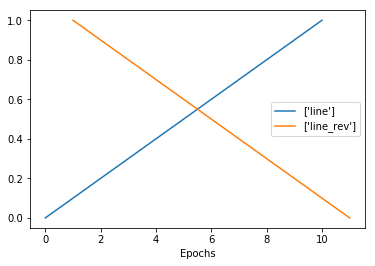

In [0]:
l=np.linspace(0,1,11)
# fig,ax=pyplot.figure(figsize=(6,4))
pyplot.figure()
pyplot.plot(range(11), l, label=['line'])
pyplot.plot(range(11,0,-1), l, label=['line_rev'])
pyplot.xlabel('Epochs')
pyplot.legend()
# pyplot.close()